# The CT dynamics is evaluated using weighted-energies

## Import part

In [1]:
# *************************************
# coded by Kosuke Sato from 2017.2.21
# *************************************
import sys
import cmath
import math
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#import utility

## Read weighted energies

In [2]:
def read_files(tsh):
    lis = []
    l = ["RM1+D-RM1","UFF-RM1","UFF-EHT"]
    for c in l:
        f = open("_weighted_energies_%s_%s.txt"%(c,tsh),"r")
        L = f.readlines()
        f.close()
        lis.append(L)
    return lis

In [3]:
au_to_eV = 27.2116
lis = {}; l = ["MSSH","MSSH_ID-A","FSSH","FSSH_ID-A"]
for c in l:
    lis[c] = read_files(c)

## Energies are set into arrays.

In [4]:
def extract_energies(L, flag):
    # [in] L: containing list including TSH popultion file.
    # [in] init_st: the orbital including excited electron at t=0 (This must be a character, that is, "HOMO", "LUMO") 
    # [in] dt: nuclear time-step : it must be 1 in Libra-GAMESS, but 10 in tutorial.
    # [in] flag: output more information 0-> not 1-> yes
    # [out] out : numpy array including TSH population
    
    au_to_fs =  0.02419   # time unit transforming : a.u. to fs
    
    Nsnaps = len(L)
    if flag == 1:
        print "number of snaps is %i" % Nsnaps
    out = {}
    out["t"] = np.zeros(Nsnaps)       # time steps
    out["min_ene"] = np.zeros(Nsnaps)
    out["ave_ene"] = np.zeros(Nsnaps)

    step = float(L[1].split()[1])
    if flag ==1:
        print "step=",step
    
    for sn in xrange(Nsnaps):
        sp = L[sn].split()
        out["t"][sn] = (float(sp[1])+step) * au_to_fs / 1000 # fsec -> psec
        out["min_ene"][sn] = float(sp[2])*au_to_eV
        out["ave_ene"][sn] = float(sp[3])*au_to_eV
    
    return out


In [5]:
ene = {}
for c in l:
    ene[c] = []
    for i in xrange(3):
        out = extract_energies(lis[c][i], flag=1); ene[c].append(out);


number of snaps is 10000
step= 20.0
number of snaps is 10000
step= 20.0
number of snaps is 10000
step= 20.0
number of snaps is 10000
step= 20.0
number of snaps is 10000
step= 20.0
number of snaps is 10000
step= 20.0
number of snaps is 10000
step= 20.0
number of snaps is 10000
step= 20.0
number of snaps is 10000
step= 20.0
number of snaps is 10000
step= 20.0
number of snaps is 10000
step= 20.0
number of snaps is 10000
step= 20.0


## fitting the energies by exponential curve: exp(-t/tau) or gaussian curve: exp(-t^2/tau^2)

In [6]:
def fit_slater(t, tau,E0):
    return E0*np.exp(-t/tau)
def fit_gaussian(t,tau,E0):
    return E0*np.exp(-t*t/tau/tau)

In [36]:
popt = []
lmethods = ["RM1+D-RM1","UFF-RM1","UFF-EHT"]
ltsh = ["MSSH","MSSH_ID-A","FSSH","FSSH_ID-A"]
time = []
for i in xrange(3):
    print "******"+lmethods[i]+" ******"
    popt_tmp = {}
    for c in ltsh:
        if i==2 or (i==0 and (c=="MSSH_ID-A" or c=="FSSH_ID-A")):
            p1, p2 = curve_fit(fit_slater, ene[c][i]["t"],ene[c][i]["ave_ene"]-ene[c][i]["min_ene"])
        else:
            p1, p2 = curve_fit(fit_gaussian, ene[c][i]["t"],ene[c][i]["ave_ene"]-ene[c][i]["min_ene"])
        print "In %s case," % c; print "tau=",p1[0]; print "E0=", p1[1]; 
        time.append(str(round(p1[0],3)))
        popt_tmp[c] = [p1[0],p1[1]]
    popt.append(popt_tmp)

******RM1+D-RM1 ******
In MSSH case,
tau= 0.172278508225
E0= 0.603771761127
In MSSH_ID-A case,
tau= 0.330287427975
E0= 0.628364588211
In FSSH case,
tau= 0.923724595599
E0= 0.532583706679
In FSSH_ID-A case,
tau= 2.67592485523
E0= 0.606028586297
******UFF-RM1 ******
In MSSH case,
tau= 0.379297626726
E0= 0.802096759725
In MSSH_ID-A case,
tau= 0.394282084942
E0= 0.840727019967
In FSSH case,
tau= 0.847544982027
E0= 0.890259786932
In FSSH_ID-A case,
tau= 1.55670736016
E0= 0.788788447114
******UFF-EHT ******
In MSSH case,
tau= 0.202786172013
E0= 1.15641203319
In MSSH_ID-A case,
tau= 1.7760315775
E0= 0.966647797306
In FSSH case,
tau= 2.27991185063
E0= 1.37523903196
In FSSH_ID-A case,
tau= 9.72361687282
E0= 1.24001288377


## Now, plot the energies.

In [37]:
def plot_energies(ene, colors, lss, labs, pax, lcolor, ynucele, time, ylabel,popt,fig_name):
    # [in] ene: dictionary including energies
    # [in] colors: list of colors ("black", "red", etc...)
    # [in] lss: list of linestyles ("-", "-.")
    # [in] labs: list of labels (shows the kind of data)
    # [in] pax: read in plt.axis(); this must be a list [xmin, xmax, ymin, ymax]
    # [in] bbox: where the legends are shown
    # [in] ylabel: label on y-axis
    # [in] p1: fitting parameters
    plt.clf() # initialization
    plt.figure(figsize=(75, 40))
    plt.subplots_adjust(wspace=0.15, hspace=0.4)
    cnt=0
    lmethod =["MSSH","MSSH+ID-A","FSSH","FSSH+ID-A"]; imethod=0
    nucele = ["RM1+D/RM1","UFF/RM1","UFF/EHT"]; inucele=0
    for i in xrange(3):
        for c in ["MSSH","MSSH_ID-A","FSSH","FSSH_ID-A"]:
            tau = popt[i][c][0]; E0 = popt[i][c][1];
            t = ene[c][i]["t"];
            plt.subplot(3,4,cnt+1);
            plt.axis([0.0,pax[cnt],0.0,1.5])
            plt.tick_params(direction="in")
            plt.rcParams["font.family"] = "Tahoma"
            plt.rcParams["axes.linewidth"] = 1.5
            plt.tick_params(direction="in")
            plt.rcParams["xtick.major.size"] = 10
            plt.rcParams["xtick.major.width"] = 1.5
            plt.rcParams["ytick.major.size"] = 10
            plt.rcParams["ytick.major.width"] = 1.5
            plt.rcParams["font.size"] = 50
            plt.xlabel("time, ps")
            plt.ylabel(ylabel)
            plt.plot(ene[c][i]["t"], ene[c][i]["ave_ene"]-ene[c][i]["min_ene"], color=colors[0], linewidth=3.5, linestyle=lss[0], label=labs[0])
            if i==2 or (i==0 and (c=="MSSH_ID-A" or c=="FSSH_ID-A")):
                plt.plot(t, fit_slater(t, tau,E0), color="blue", linewidth=3.5, linestyle="-.",label="fitting")
            else:
                plt.plot(t, fit_gaussian(t, tau,E0), color="blue", linewidth=3.5, linestyle="-.",label="fitting")
            if cnt==11:
                plt.text(0.2*pax[cnt],0.4,time[cnt]+" ps",fontsize=80)
            else:
                plt.text(0.5*pax[cnt],0.8,time[cnt]+" ps", fontsize=80)
            plt.text(0.45*pax[cnt],-0.5,labs[cnt], fontsize=80)
            #plt.legend(fontsize=36, loc="upper center",bbox_to_anchor=bbox[i])
            if cnt <4: # TSH method
                plt.text(0.5*pax[cnt],1.6,lmethod[imethod],fontsize=80,horizontalalignment='center',color=lcolor[cnt/2]); imethod+=1
            if cnt%4 ==0:  # nuclear/electronic methodology
                plt.text(-0.225*pax[cnt],ynucele[inucele],nucele[inucele],fontsize=80,horizontalalignment='center',rotation=90); inucele+=1
            cnt+=1
    plt.savefig(fig_name,bbox_inches="tight")
    plt.show()

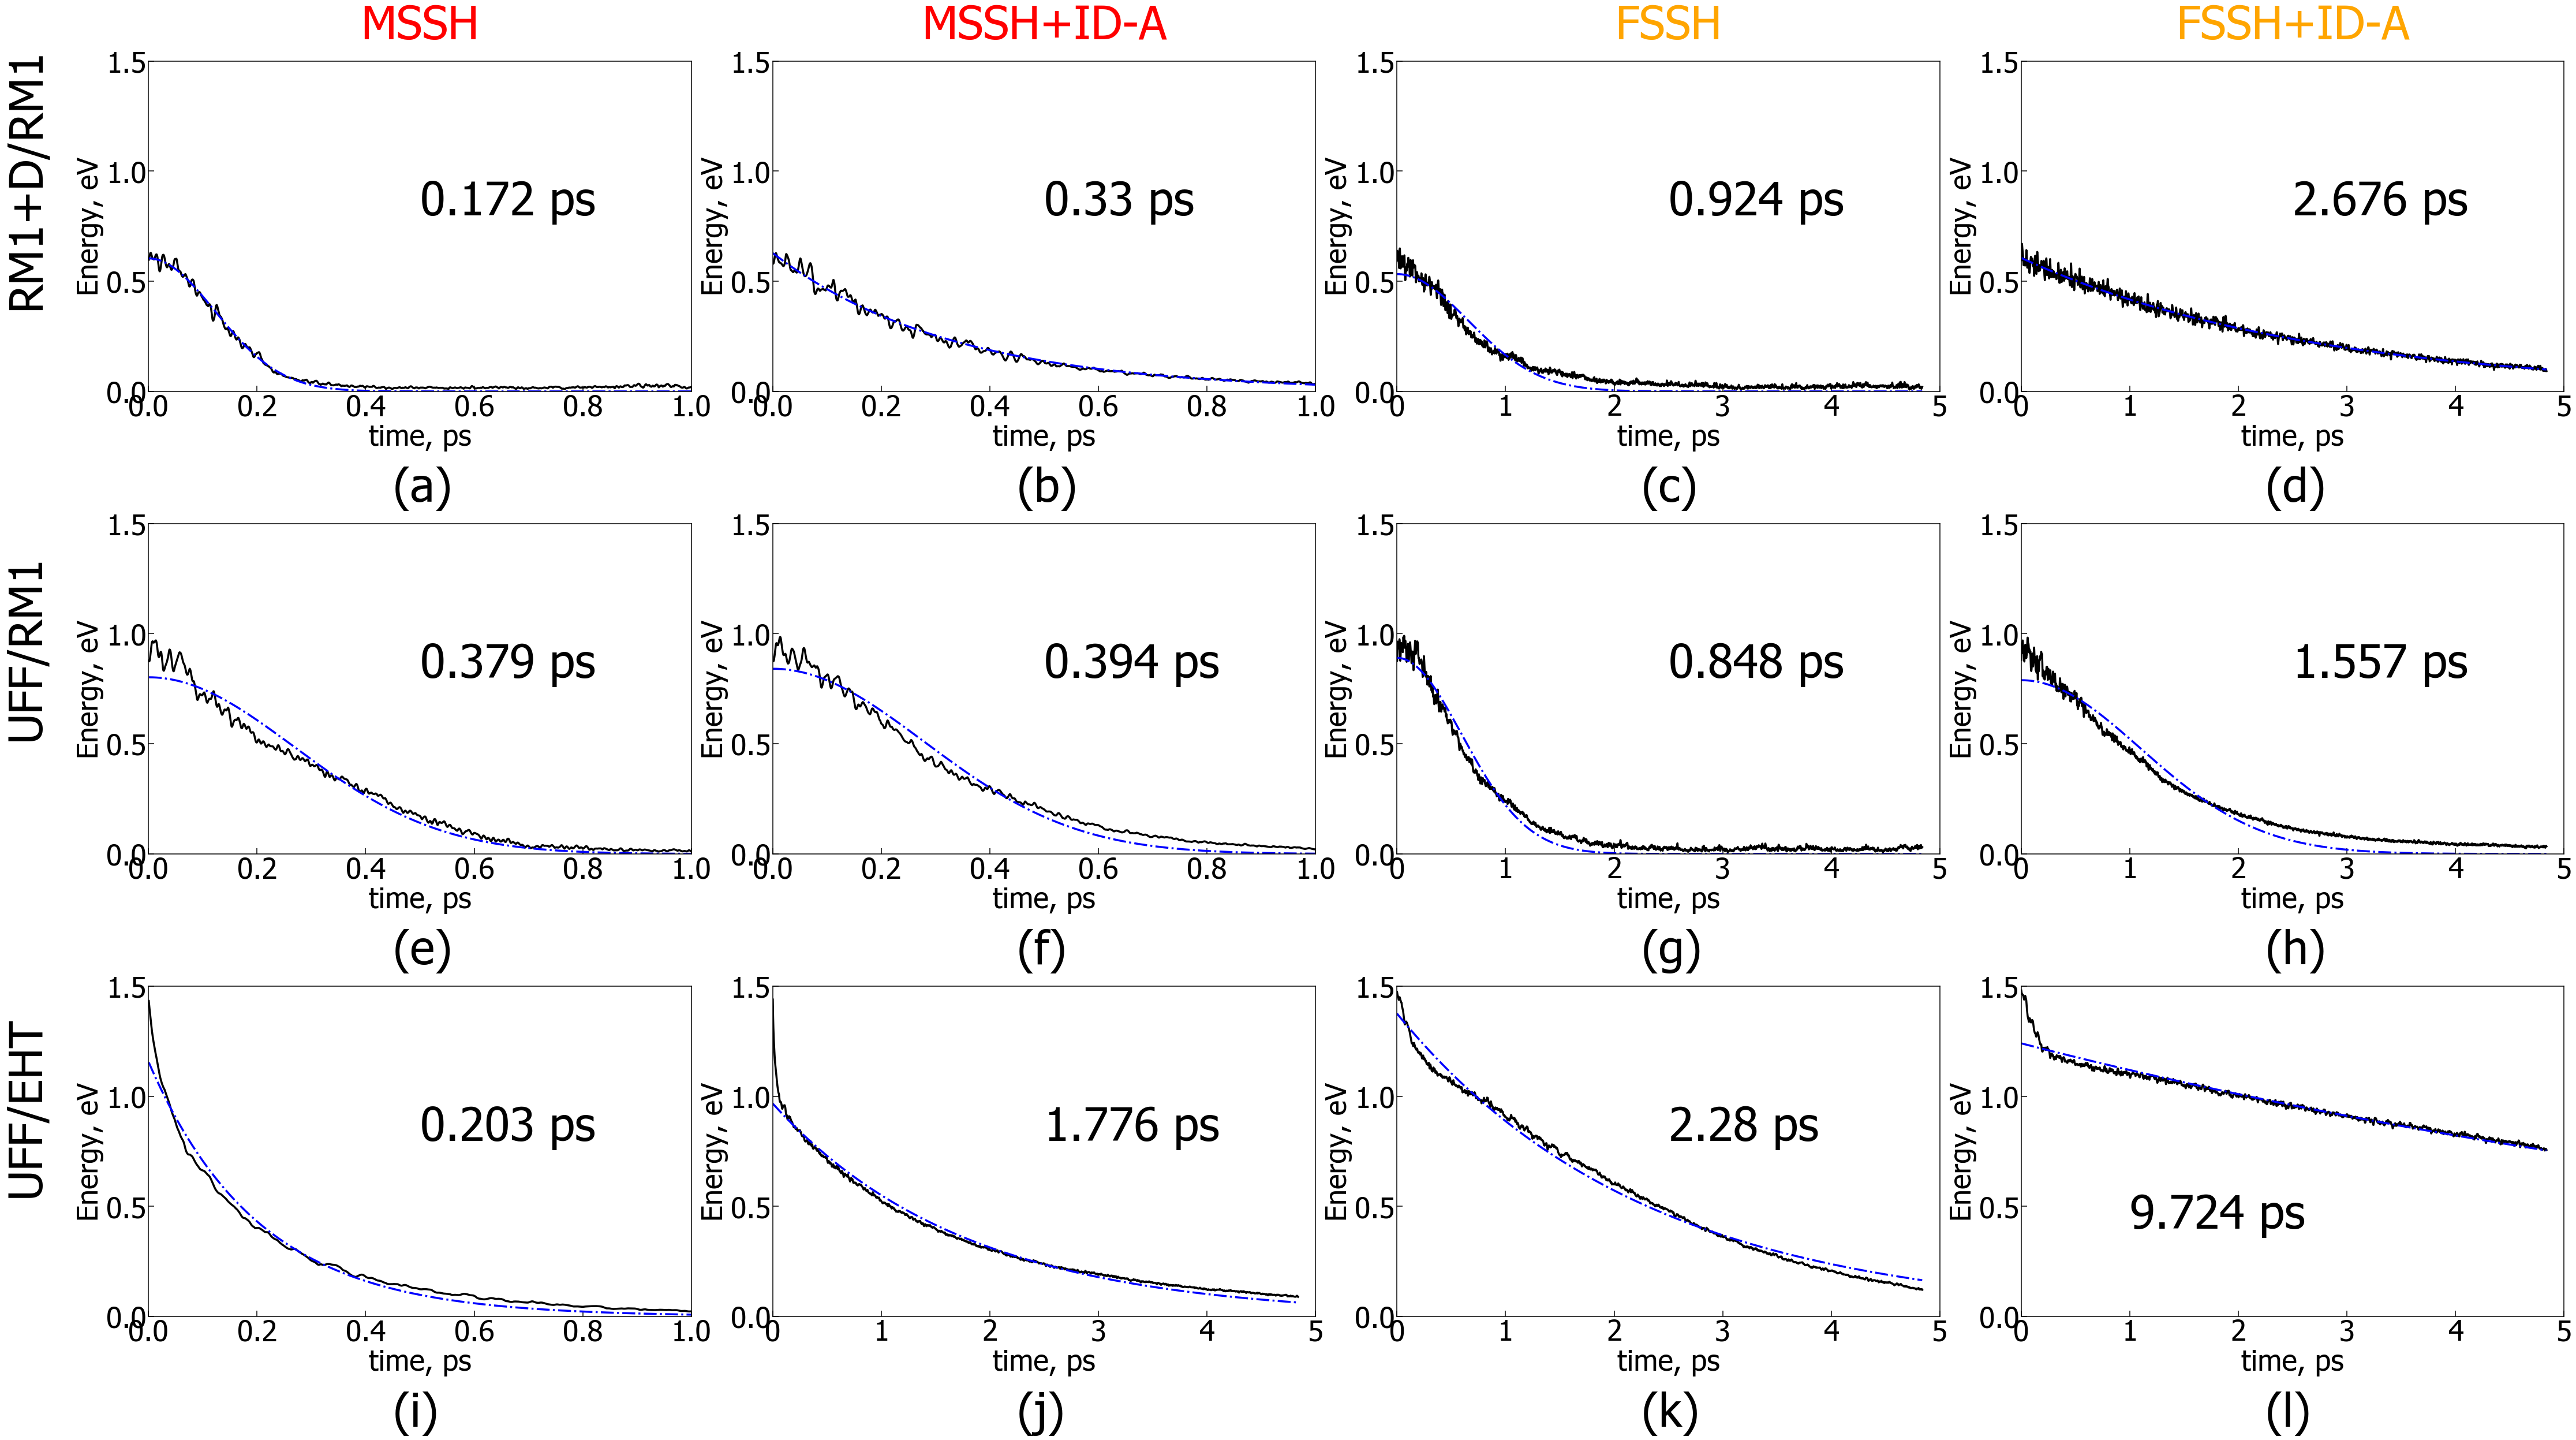

In [39]:
pax =[1.0,1.0,5.0,5.0,1.0,1.0,5.0,5.0,1.0,5.0,5.0,5.0]
labs = ["(a)","(b)","(c)","(d)","(e)","(f)","(g)","(h)","(i)","(j)","(k)","(l)"]
ynucele = [1.4,1.2,1.2]
lcolor = ["red","orange"]
plot_energies(ene, ["black"],\
                ["-"], labs,pax,lcolor,ynucele,time, "Energy, eV",popt,"dynamics_excitation_energies.eps")